# 0. Setup

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from data_enginerring.targets_set import TARGETS, TargetSet
from data_enginerring.feature_set import STATIC_FEATURES, MICROSTRUCTURE_FEATURES, DeltasFeatureSet

SEED = 67
random.seed(SEED)
np.random.seed(SEED)

# 1. Data

## 1. Loading and Pre-processing

In [31]:
dataset_benchmark = pd.read_csv("data/dataset_benchmark.csv", parse_dates=["first_trade_time"])
dataset_expanded = pd.read_csv("data/dataset_expanded.csv", parse_dates=["first_trade_time"])
assert len(dataset_benchmark) == len(dataset_expanded), "Mismatch in tokens included."

def pool_type_identification(x):
    return int(x == "675kPX9MHTjS2zt1qfr1NYHuzeLXfQM9H24wFSUt1Mp8")
dataset_benchmark["pool_type"] = dataset_benchmark["pool_type"].transform(pool_type_identification)
dataset_expanded["pool_type"] = dataset_expanded["pool_type"].transform(pool_type_identification)

dataset_benchmark = dataset_benchmark.sort_values(['first_trade_time', 'token_mint']).set_index('first_trade_time')
dataset_expanded = dataset_expanded.sort_values(['first_trade_time', 'token_mint']).set_index('first_trade_time')

dataset_expanded.head()

,token_mint,pool_type,has_pumpdotfun_history,token_decimals,n_transfers,n_swaps,n_buys,n_lp_addition_like,n_lp_removal_like,buy_percentage,...,kyle_lambda,roll_spread,roll_percentage_spread,amihud_illiquidity,vpin,md_price_no_post_rc_0.9_0.01,md_price_no_post_rc_0.99_0.005,md_liq_no_post_rc_0.99_0.01,md_liq_0.9,idle_300
first_trade_time,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:31+00:00,3wii3WDRkhScqZvp3q3QvUNPr4w34QF4ydQTbnE5ytKm,1,0,6,382,381,294,1,0,0.769634,...,0.048559,-1802.050086,-7.630116,8.682559e+03,0.516330,1,1,1,1,1
2024-10-01 00:01:13+00:00,HumFbCWH77CiYuwVFV163RYB9Fa7vxqKCCPsz9gspump,1,1,6,600,599,313,1,0,0.521667,...,0.003868,48.157616,0.917897,2.514349e+04,0.427266,1,0,0,0,0
2024-10-01 00:11:09+00:00,2vrTSA71k2JnbT7VdyHqGcyjBNvncHcLPuECPXbUzLkp,1,0,6,159,158,108,1,0,0.679245,...,0.007659,-5827.446046,-88.979381,9.978782e+03,0.997319,0,0,0,0,0
2024-10-01 00:13:18+00:00,7NkeDHRC9ERbZ79ca3hkGvr1UDF2VnAPjNqw81tt4CK5,1,0,6,627,626,444,1,0,0.708134,...,921.830877,-388299.439415,-15.663166,6.692039e+03,0.994968,1,1,1,1,1
2024-10-01 00:14:58+00:00,E7NvJPn2HGvYbqJAKpTNC4spozq9gngQFDkCfVRdkUM6,1,0,9,729,727,131,1,1,0.179698,...,0.005655,-99.042811,NaN,3.668076e+10,0.974120,0,0,1,1,1


In [32]:
meta_columns = ["token_mint", "first_trade_time"]
targets = TargetSet(TARGETS).targets_list
features_benchmark = [c for c in dataset_benchmark.columns if c not in meta_columns + targets]
features_expanded = [c for c in dataset_expanded.columns if c not in meta_columns + targets]

X_bench = dataset_benchmark[features_benchmark]
X_exp = dataset_expanded[features_expanded]
y = dataset_benchmark[targets]

## 1.2. Data Exploration

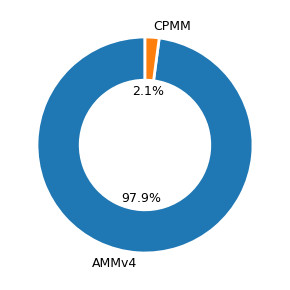

In [33]:
counts = X_bench.groupby("pool_type").pool_type.count().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6, 3))
ax.pie(counts, labels=["AMMv4", "CPMM"],
       autopct="%1.1f%%", pctdistance=0.5, startangle=90,
       wedgeprops=dict(edgecolor="white", linewidth=2, width=0.4),
       textprops=dict(fontsize=9))
plt.tight_layout()
plt.show()

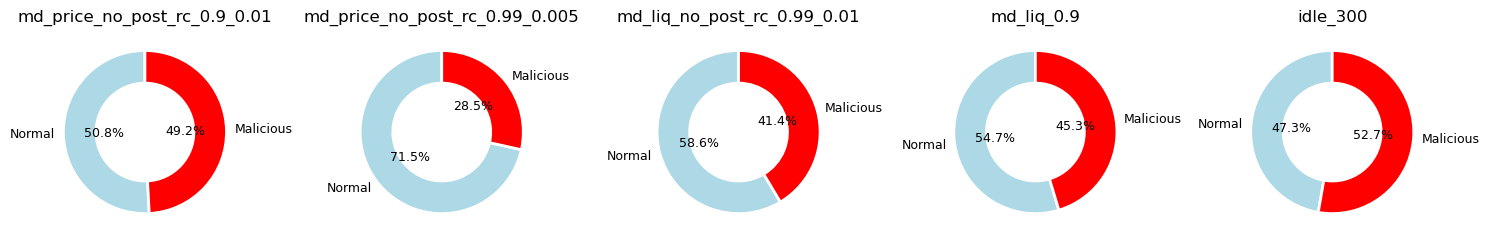

In [34]:
n_targets = len(targets)
fig, ax = plt.subplots(1, n_targets, figsize=(n_targets * 3, 3))

colors = ["lightblue", "red"]
labels = ["Normal", "Malicious"]

for i, target in enumerate(targets):
    counts = y[target].value_counts().sort_index()
    ax[i].pie(counts, labels=labels, colors=colors,
              autopct="%1.1f%%", pctdistance=0.5, startangle=90,            # include percentage
              wedgeprops=dict(edgecolor="white", linewidth=2, width=0.4),   # "donut" plot
              textprops=dict(fontsize=9))
    ax[i].set_title(target)
plt.tight_layout()
plt.show()

# 2. Basic A/B Test

## 2.1. Training

In [35]:
start_test = '2024-11-01'
train_idx, test_idx = dataset_benchmark.index < start_test, dataset_benchmark.index >= start_test

X_bench_train, X_exp_train, y_train = X_bench[train_idx], X_exp[train_idx], y[train_idx]
X_bench_test, X_exp_test, y_test = X_bench[test_idx], X_exp[test_idx], y[test_idx]
X_exp_train.head()

,pool_type,has_pumpdotfun_history,token_decimals,n_transfers,n_swaps,n_buys,n_lp_addition_like,n_lp_removal_like,buy_percentage,sell_percentage,...,first_sell_rel_ts,avg_rsi_6,std_rsi_6,avg_rsi_12,std_rsi_12,kyle_lambda,roll_spread,roll_percentage_spread,amihud_illiquidity,vpin
first_trade_time,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:31+00:00,1,0,6,382,381,294,1,0,0.769634,0.227749,...,24.0,54.943875,10.322659,54.146780,5.224459,0.048559,-1802.050086,-7.630116,8.682559e+03,0.516330
2024-10-01 00:01:13+00:00,1,1,6,600,599,313,1,0,0.521667,0.476667,...,2.0,44.483709,19.165070,47.405397,11.957105,0.003868,48.157616,0.917897,2.514349e+04,0.427266
2024-10-01 00:11:09+00:00,1,0,6,159,158,108,1,0,0.679245,0.314465,...,1.0,54.781867,5.880839,58.270899,0.608321,0.007659,-5827.446046,-88.979381,9.978782e+03,0.997319
2024-10-01 00:13:18+00:00,1,0,6,627,626,444,1,0,0.708134,0.290271,...,4.0,49.661232,11.020860,50.070581,5.639549,921.830877,-388299.439415,-15.663166,6.692039e+03,0.994968
2024-10-01 00:14:58+00:00,1,0,9,729,727,131,1,1,0.179698,0.817558,...,42.0,55.626619,28.892618,44.614102,19.053823,0.005655,-99.042811,NaN,3.668076e+10,0.974120


md_price_no_post_rc_0.9_0.01
0.8722997328950073 0.8779633268649842


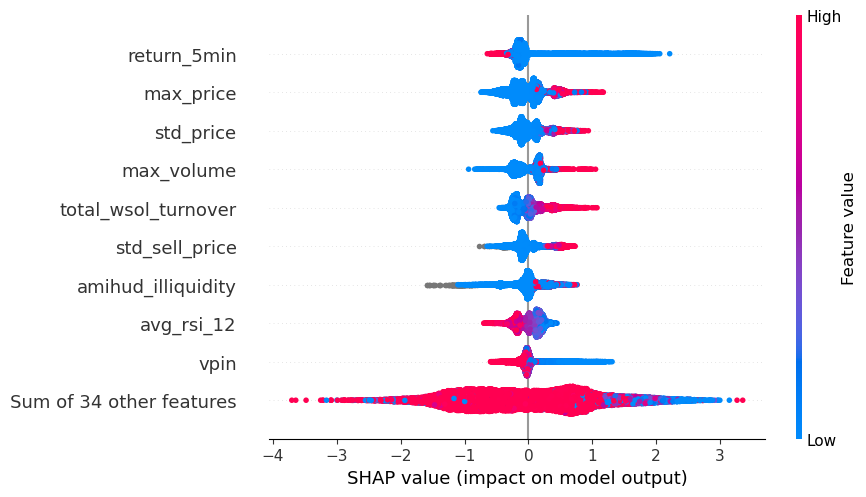

md_price_no_post_rc_0.99_0.005
0.9449667069464901 0.8733379839756733


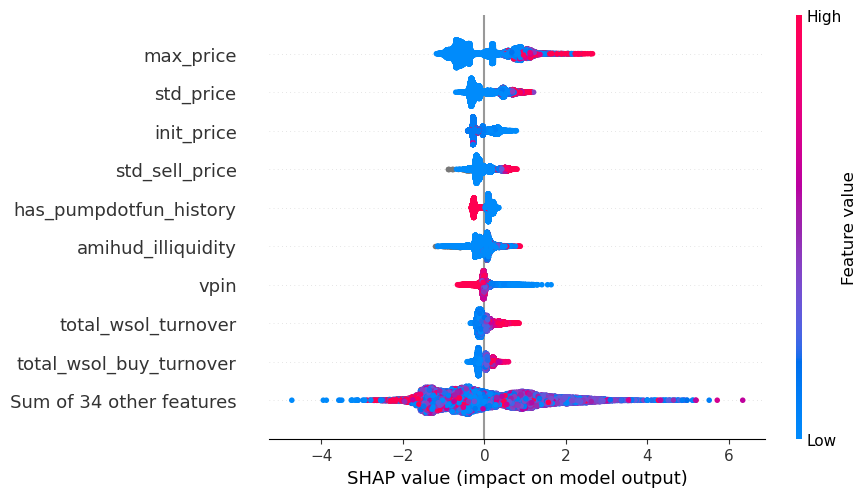

md_liq_no_post_rc_0.99_0.01
0.9686764195633109 0.9466656242905955


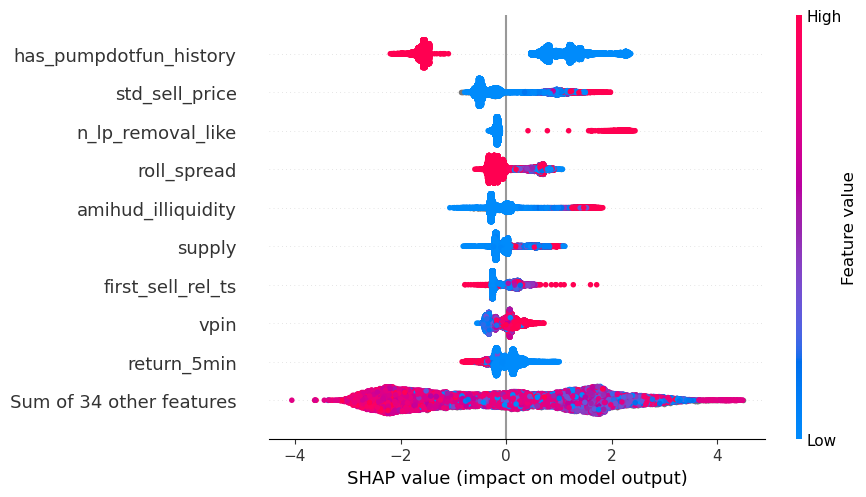

md_liq_0.9
0.9617404226890239 0.9478470366968168


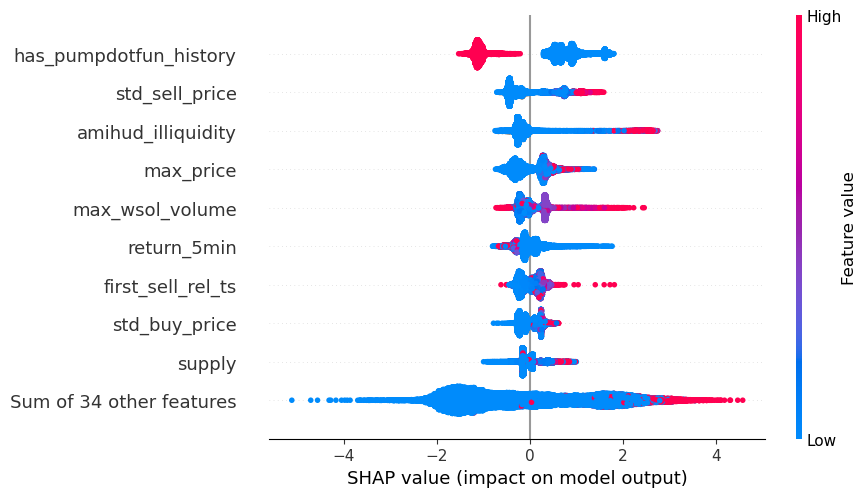

idle_300
0.8986027514022698 0.9029749246511394


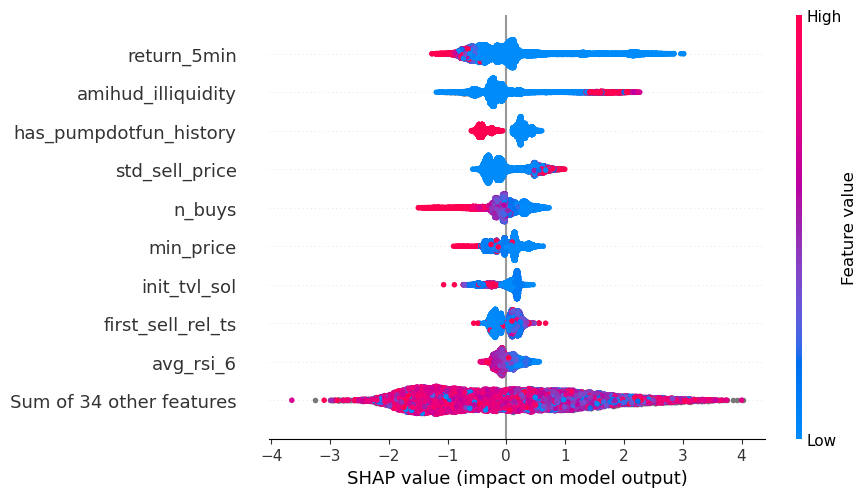

In [36]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
import shap

shap.initjs()
# mm_features = DeltasFeatureSet(MICROSTRUCTURE_FEATURES).features_list

for target in targets:
    print(target)

    model = CatBoostClassifier(verbose=0, random_seed=SEED)
    model.fit(X_exp_train, y_train[target])
    prediction = model.predict_proba(X_exp_test)[:,1]
    print(roc_auc_score(y_test[target], prediction), average_precision_score(y_test[target], prediction))

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_exp_train)
    # shap.plots.beeswarm(shap_values[:,mm_features])
    shap.plots.beeswarm(shap_values)

In [37]:
# from sklearn.ensemble import RandomForestClassifier

# for target in targets:
#     print(target)
#     features_temp = [c for c in X_exp.columns if c != "has_pumpdotfun_history"]

#     model = RandomForestClassifier(random_state=SEED)
#     model.fit((X_exp_train[features_temp]), y_train[target])
#     print("fit done!")
#     prediction = model.predict_proba(X_exp_test[features_temp])[:,1]
#     print(roc_auc_score(y_test[target], prediction), average_precision_score(y_test[target], prediction))

#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer(X_exp_train[features_temp])
#     shap.plots.beeswarm(shap_values)